# Explanation

universe: SP100

data period: last 2 years

alpha: I assume I can generate the daily targeted positions at close and rebalance at close. The simple strategy is just a dollar-neutral one at 20M USD gross booksize based on a simple weekly reversion with a linear decay smoothing then following by normalization stocks against all stocks in the same sectors. Actually using mean-reversion will exhibit a bias because we do not use the historical Sp100 constituents but I will just want to show this most basic starting idea I normally try for the price-volume data anyway.

matrices: the annual return, the annual Sharpe ratio and the maximum drawdown are shown for the illustration.

In [1]:
import pandas as pd
import yfinance as yf
import requests
import bs4 as bs
import datetime
import numpy as np

In [2]:
def data_download():
    resp = requests.get('http://en.wikipedia.org/wiki/S%26P_100')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    sectors = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if ticker.strip() != 'GOOG':
            if ticker.strip() == 'BRK.B':
                ticker = 'BRK-B'
            tickers.append(ticker)
            sector = row.findAll('td')[2].text
            sectors.append(sector)
    tickers = [s.replace('\n', '') for s in tickers]
    sectors = [s.replace('\n', '') for s in sectors]
    return tickers, sectors

In [3]:
def neutralize(alphas, group):
    a = alphas.copy()
    for g in group:
        a[group[g]] = a[group[g]].sub(a[group[g]].mean(axis=1), axis=0)
    return a
def decay(alphas, days):
    weights = np.arange(1, days + 1)
    return alphas.rolling(days).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
def scale_to_book(alphas, booksize=20e6):
    return booksize * alphas.div(alphas.abs().sum(axis=1), axis=0)

In [4]:
tickers, sectors = data_download()

In [5]:
sector_dict = {}
for i in range(len(tickers)):
    if sectors[i] in sector_dict:
        sector_dict[sectors[i]].append(tickers[i])
    else:
        sector_dict[sectors[i]] = [tickers[i]]

In [6]:
start = datetime.datetime(2019, 8, 11)
end = datetime.datetime(2021, 8, 10)

In [7]:
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  100 of 100 completed


In [8]:
adj_close = data['Adj Close']

In [9]:
adj_ret = adj_close / adj_close.shift(1) - 1

In [10]:
book_size = 20e6

In [11]:
ret_days = 5

In [12]:
alphas = -(adj_close / adj_close.shift(ret_days) - 1)

In [13]:
dec_days = 3
alphas_dec = decay(alphas, dec_days)
alphas_norm = neutralize(alphas_dec, sector_dict)
pos = scale_to_book(alphas_norm, book_size)

In [14]:
pnl = pos.shift(1) * adj_ret

In [15]:
index_shift = ret_days + dec_days

<AxesSubplot:title={'center':'cum pnl(USD)'}, xlabel='Date'>

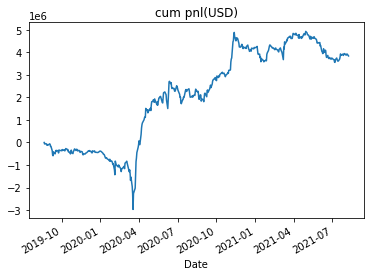

In [16]:
pnl.sum(axis=1).cumsum().iloc[(index_shift - 1):].plot(title='cum pnl(USD)')

In [17]:
ann_ret = 250 * pnl.sum(axis=1).iloc[index_shift:].mean() / book_size
ann_sharpe = 250 ** 0.5 * pnl.sum(axis=1).iloc[index_shift:].mean() / pnl.sum(axis=1).iloc[index_shift:].std() 
max_dd = (pnl.sum(axis=1).cumsum().cummax() - pnl.sum(axis=1).cumsum()).max() / book_size

In [18]:
print('ann ret(%) =', ann_ret*100)
print('ann SR =', ann_sharpe)
print('max DD(%) =', max_dd*100)

ann ret(%) = 9.70324800154401
ann SR = 0.9256366604003348
max DD(%) = 14.858578280278259
